### 1 - Parameters of a cubic function
https://www.learnpytorch.io/01_pytorch_workflow/

In [7]:
import torch
from torch import nn
import matplotlib.pyplot as plt
#device = "cuda" if torch.cuda.is_available() else "cpu"
device="cpu"
torch.__version__

'2.5.1+cu124'

Create "Known" parameters

In [8]:
# Create *known* parameters
weights = torch.tensor([1.0, 3.0, 2.0], device=device)
bias = torch.tensor(-1.0, device=device)

#Creates powers
powers = torch.arange(len(weights), 0, -1, device=device)

# Create data
start = -2
end = 1
step = 0.02
X = torch.arange(start, end, step, device=device).unsqueeze(dim=1)
y = torch.sum(weights * torch.pow(X, powers), dim=1) + bias

X[:10], y[:10]

(tensor([[-2.0000],
         [-1.9800],
         [-1.9600],
         [-1.9400],
         [-1.9200],
         [-1.9000],
         [-1.8800],
         [-1.8600],
         [-1.8400],
         [-1.8200]]),
 tensor([-1.0000, -0.9612, -0.9247, -0.8906, -0.8587, -0.8290, -0.8015, -0.7761,
         -0.7527, -0.7314]))

Train test split

In [9]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(120, 120, 30, 30)

Plotting function

In [10]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

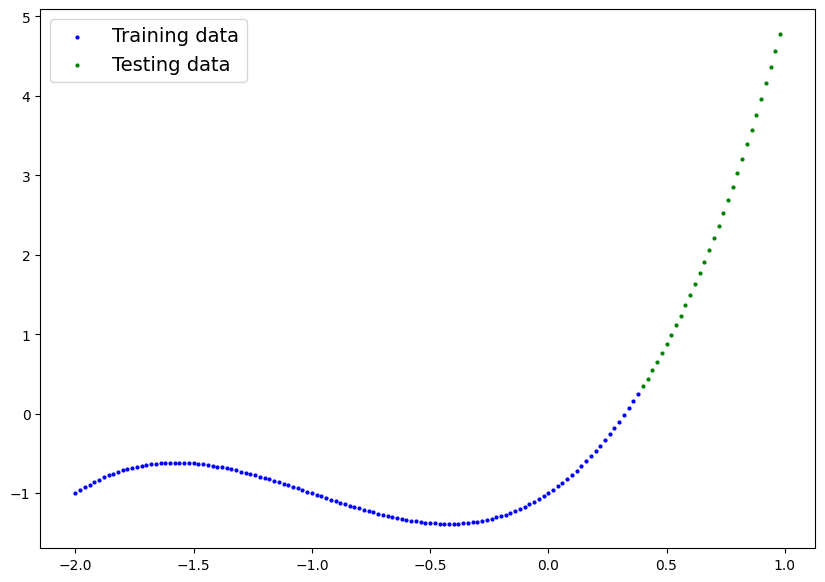

In [11]:
plot_predictions();

Cubic model

In [ ]:
# # Create a Linear Regression model class
# class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
#     def __init__(self):
#         super().__init__()
#         self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
#                                                 dtype=torch.float), # <- PyTorch loves float32 by default
#                                    requires_grad=True) # <- can we update this value with gradient descent?)

#         self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
#                                             dtype=torch.float), # <- PyTorch loves float32 by default
#                                 requires_grad=True) # <- can we update this value with gradient descent?))

#     # Forward defines the computation in the model
#     def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
#         return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)


In [12]:
class CubicRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.rand(3, device=device), requires_grad=True)
    self.bias = nn.Parameter(torch.rand(1, device=device), requires_grad=True)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    powers = torch.arange(len(self.weights), 0, -1, device=device)
    return torch.sum(self.weights * torch.pow(x, powers), dim=1) + self.bias

Initialize cubic model

Initial parameters:
OrderedDict({'weights': tensor([0.8823, 0.9150, 0.3829]), 'bias': tensor([0.9593])})


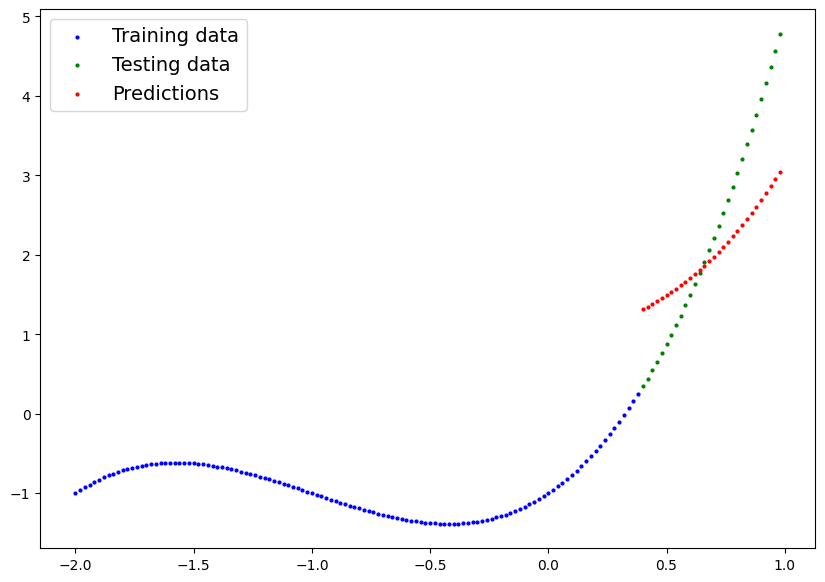

In [13]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = CubicRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
print(f"Initial parameters:\n{model_0.state_dict()}")

# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

#Plot initial predictions
plot_predictions(predictions=y_preds)

In [14]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.8823, 0.9150, 0.3829], requires_grad=True),
 Parameter containing:
 tensor([0.9593], requires_grad=True)]

Train cubic model

In [15]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01)

In [18]:
torch.manual_seed(42)

#Set number of epochs
epochs = 10000

#Bookeeping
train_loss_values, test_loss_values, epoch_count = [], [], []

for epoch in range(epochs):
  ### Training

  #Put model in train mode
  model_0.train()

  # 1. Forward pass on train data using the forward() method
  y_pred = model_0.forward(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train)

  # 3. Zero grad of the optimizer, or else the gradients accumulate
  optimizer.zero_grad()

  # 4. Backpropogate loss
  # https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944/2
  loss.backward()

  # 5. Update model parameters from x.grad = dloss/dx
  optimizer.step()

  ### Testing

  #6. Put model in eval mode
  model_0.eval()

  with torch.inference_mode():
    # 7. Forward pass on test data
    test_pred = model_0.forward(X_test)

    # 8. Compute loss on test set
    test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

    # Print out what's happening
    if epoch % 1000 == 0:
          epoch_count.append(epoch)
          train_loss_values.append(loss.detach().numpy())
          test_loss_values.append(test_loss.detach().numpy())
          print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")


Epoch: 0 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 1000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 2000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 3000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 4000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 5000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 6000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 7000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 8000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 
Epoch: 9000 | MAE Train Loss: 0.034637682139873505 | MAE Test Loss: 0.038159601390361786 


In [19]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.9504, 2.9488, 2.0015], requires_grad=True),
 Parameter containing:
 tensor([-0.9904], requires_grad=True)]

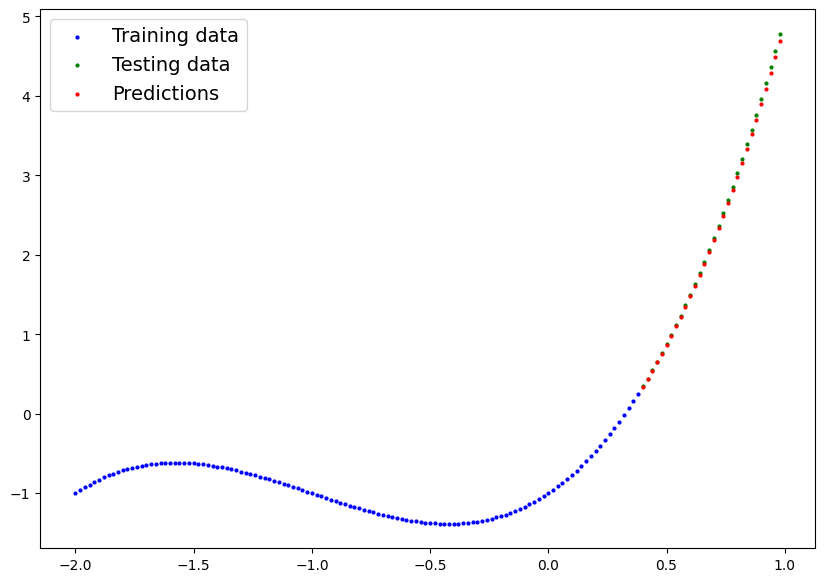

In [20]:
model_0.eval()

with torch.inference_mode():
  y_preds = model_0(X_test)

plot_predictions(predictions=y_preds)

Save model

In [21]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


Read in saved model and infer

In [25]:
MODEL_PATH = "models/01_pytorch_workflow_model_1.pth"
loaded_model_1 = CubicRegressionModel()
loaded_model_1.load_state_dict(torch.load(MODEL_PATH))

loaded_model_1.to(device)
list(model_0.parameters())

C:\Users\thefu\AppData\Local\Temp\ipykernel_12304\2040883186.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_1.load_state_dict(torch.load(MODEL_PATH))


[Parameter containing:
 tensor([0.9504, 2.9488, 2.0015], requires_grad=True),
 Parameter containing:
 tensor([-0.9904], requires_grad=True)]

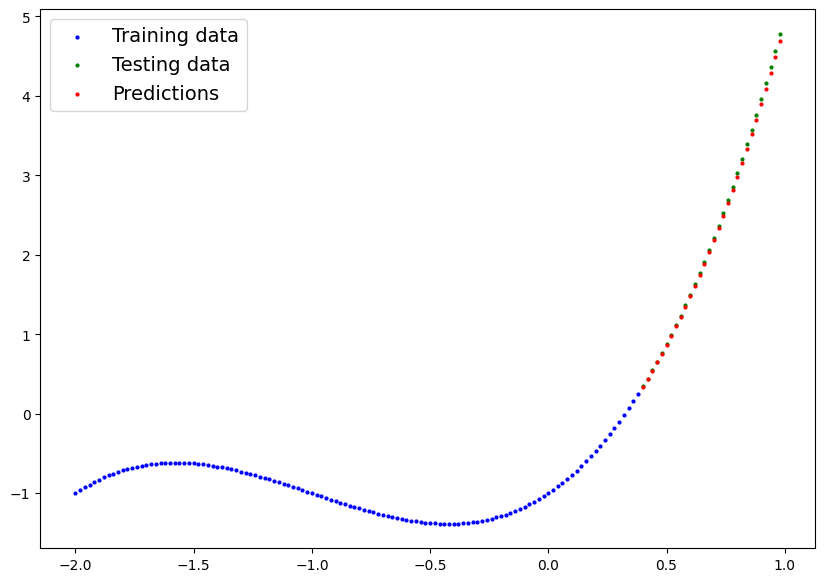

In [26]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

plot_predictions(predictions=loaded_model_1_preds)